# **COMP 1019P AU4 Sessions 1, 2, and 3: Ubicomp SOAR tutorial -- 2024 -- 6 Oct**



Please **save a copy of this Colab notebook into your Drive** before you start working.

This can be done by clicking on *File > Save a Copy in Drive*.


In [1]:
%load_ext autoreload
%autoreload 2

## Google Drive Mounting

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


## Directories

In [3]:
import os
import sys

# base_directory = "/content/soar/" # Uncomment this if you wish not to use Google Drive
base_directory = "/content/gdrive/MyDrive/ubicomp2024_soar/"
repo = os.path.join(base_directory, "soar_2024")

In [4]:
%%capture
!pip install numpy scipy scikit-learn seaborn matplotlib pandas lightly

In [5]:
import numpy as np
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import random
import glob
from datetime import date
import itertools
import pickle

# progress bar
from tqdm.auto import tqdm

# Various metrics
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# Setting seeds
np.random.seed(42)
random.seed(42)

from google.colab import files

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [6]:
os.makedirs(base_directory, exist_ok=True)
%cd $base_directory

/content/gdrive/MyDrive/ubicomp2024_soar


In [7]:
def plot_accelerometer_timeseries(timeseries, title="", figsize=(15,6), xlim=None, ylim=None):
    plt.figure(figsize=figsize)
    if len(timeseries.shape) == 1:
        plt.plot(timeseries)
    else:
        for i in range(3):
            plt.plot(timeseries[:, i], label=["x","y","z"][i])
    if xlim is None:
        plt.xlim(0, len(timeseries))
    else:
        plt.xlim(*xlim)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.title(title, fontsize=16)
    plt.legend()
    plt.show()

label_mapping = {
    0: "Downstairs",
    1: "Upstairs",
    2: "Walking",
    3: "Jogging",
    4: "Standing",
    5: "Sitting",
}
num_ticks = 6
cm_ticks = np.linspace(0, num_ticks-1, num_ticks, dtype=int)
cm_ticklabels = [label_mapping[idx] for idx in cm_ticks]


## **Cloning the existing repository with the code**




In [8]:
!if cd $repo; then git pull; else git clone https://github.com/ubicompsoartutorial/soar_2024.git; fi
%cd $repo

/bin/bash: line 1: cd: /content/gdrive/MyDrive/ubicomp2024_soar/soar_2024: No such file or directory
Cloning into 'soar_2024'...
remote: Enumerating objects: 409, done.
remote: Counting objects: 100% (409/409), done.
remote: Compressing objects: 100% (399/399), done.
remote: Total 409 (delta 9), reused 404 (delta 8), pack-reused 0 (from 0)
Receiving objects: 100% (409/409), 19.55 MiB | 8.69 MiB/s, done.
Resolving deltas: 100% (9/9), done.
Updating files: 100% (387/387), done.
/content/gdrive/MyDrive/ubicomp2024_soar/soar_2024


# 0 Data Preparation

## 0.1 **Downloading the Motionsense data**

Already available in the Github repo! So, there is not need to download!

## 0.2 Data pre-processing

In [9]:
%cd $repo
import data_preparation.prepare_motionsense as prepare

# Loading the arguments first
args = prepare.load_args()
print(args)

# Obtaining the processed data
processed = prepare.prepare_data(args)

/content/gdrive/MyDrive/ubicomp2024_soar/soar_2024
Parameters for preparing Motionsense
{'dataset_loc': 'data', 'original_sampling_rate': 50, 'sampling_rate': 50}
['dws_1', 'dws_11', 'dws_2', 'jog_16', 'jog_9', 'sit_13', 'sit_5', 'std_14', 'std_6', 'ups_12', 'ups_3', 'ups_4', 'wlk_15', 'wlk_7', 'wlk_8']


  0%|          | 0/15 [00:00<?, ?it/s]

Done collecting!
The unique subjects are: [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24.]
The train, val and test subjects are: {}
{'train': array([ 4., 15., 22., 24., 11., 20.,  2.,  5.,  7.,  6., 21., 16., 23.,
        8., 13.]), 'val': array([10.,  3., 18., 14.]), 'test': array([ 9., 17.,  1., 19., 12.])}
train	 data shape = (883942, 3) 	 label shape = (883942,)
val	 data shape = (245221, 3) 	 label shape = (245221,)
test	 data shape = (304662, 3) 	 label shape = (304662,)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 1280x960 with 0 Axes>

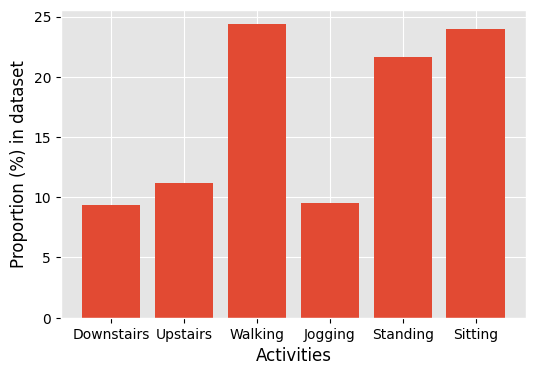

In [10]:
plt.style.use('ggplot')
plt.figure(dpi=200)

fig, axs = plt.subplots(1, 1, figsize=(6, 4))
all_labels = np.concatenate((processed['train']['labels'], processed['val']['labels'], processed['test']['labels']))

labels, counts = np.unique(all_labels, return_counts=True)
axs.bar(labels, (counts*100.0)/np.sum(counts))
axs.set_xticks(range(6), range(6))
axs.set_xticklabels(['Downstairs', 'Upstairs', 'Walking', 'Jogging', 'Standing', 'Sitting'])
axs.set_xlabel("Activities")
axs.set_ylabel("Proportion (%) in dataset")

axs.xaxis.label.set_color('black') # x-axis labels
axs.yaxis.label.set_color('black') # y-axis labels

axs.tick_params(axis='x', colors='black')    #setting up X-axis tick color to red
axs.tick_params(axis='y', colors='black')  #setting up Y-axis tick color to black

plt.savefig("motionsense_class_size.pdf", bbox_inches='tight')
files.download("motionsense_class_size.pdf")

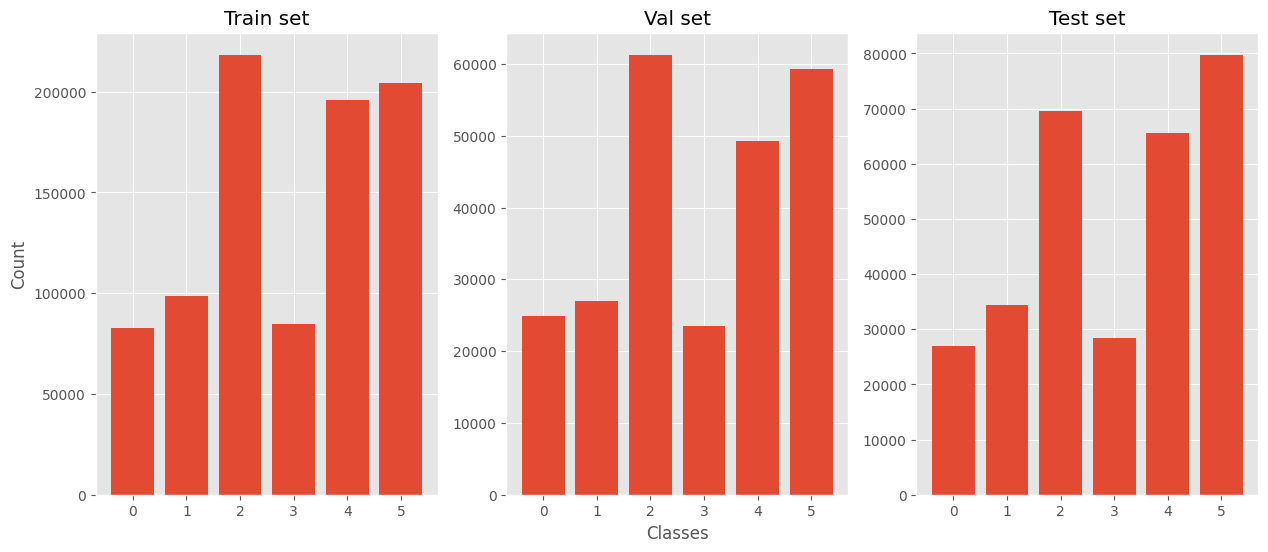

In [11]:
plt.style.use('ggplot')
fig, axs = plt.subplots(1, 3, figsize=(15, 6))
for i, split, title in zip(range(3), ['train', 'val', 'test'], ["Train", "Val", "Test"]):
    labels, counts = np.unique(processed[split]['labels'], return_counts=True)
    axs[i].bar(labels, counts)
    axs[i].set_title(title + " set")
    axs[i].set_xticks(range(6), range(6))
    # axs[i].set_ylim([0, 65000])
axs[0].set_ylabel("Count")
axs[1].set_xlabel("Classes")
# plt.ylim([0, 65000])
plt.show()

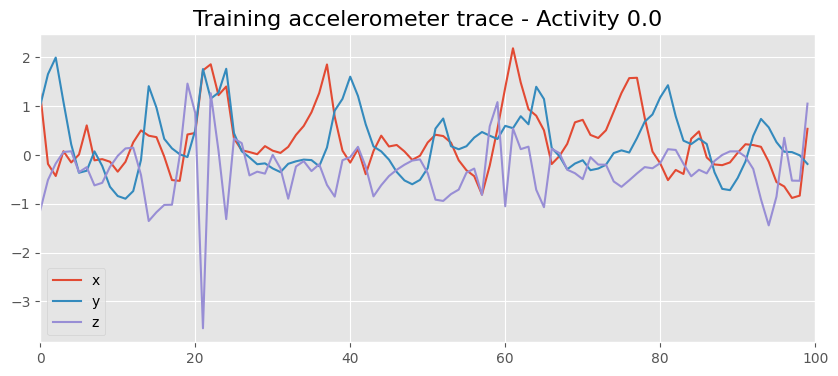

In [12]:
plot_accelerometer_timeseries(processed['train']['data'][:100], f"Training accelerometer trace - Activity {processed['train']['labels'][100]}", figsize=(10,4))


# 1 Activity Recognition Chain

## 1.0 **Segmentation: obtaining windows of sensor data through sliding window**

### Goal: take stream of sensor data and return windows + labels


In [13]:
processed_data_files = glob.glob(os.path.join(repo, "data_preparation", "all_data", "*", "motionsense.pkl"))
processed_data_files.sort(key=os.path.getmtime)
processed_data_file = processed_data_files[-1]
processed = pd.read_pickle(processed_data_file)
processed_data_file

'/content/gdrive/MyDrive/ubicomp2024_soar/soar_2024/data_preparation/all_data/Jan-27-2025/motionsense.pkl'

In [14]:
import ecdf.extract_ecdf_train_classifier as ecdf

# Obtaining the segmented data
segmented_data = ecdf.generate_windowed_data(processed=processed)

(17677, 100, 3) (17677,)
(4903, 100, 3) (4903,)
(6092, 100, 3) (6092,)


### Before Segmentation

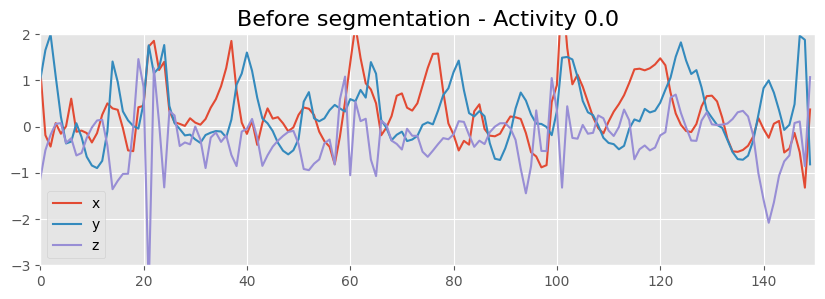

In [15]:
plot_accelerometer_timeseries(processed['train']['data'][:150], f"Before segmentation - Activity {processed['train']['labels'][150]}", ylim=(-3,2), figsize=(10,3))

### After Segmentation

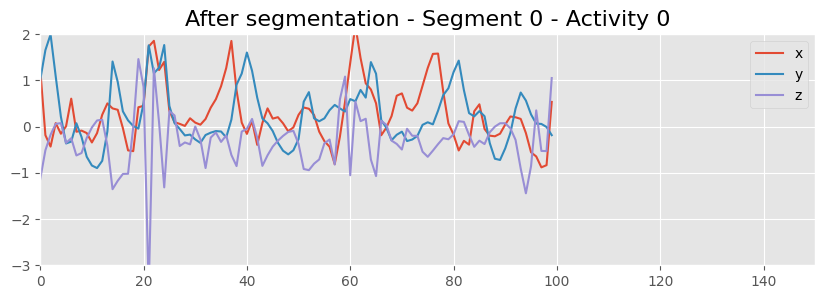

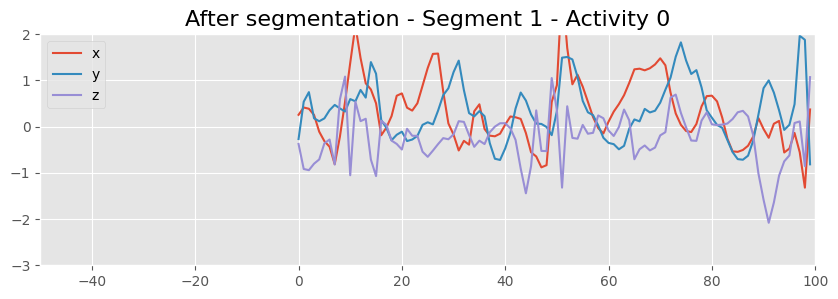

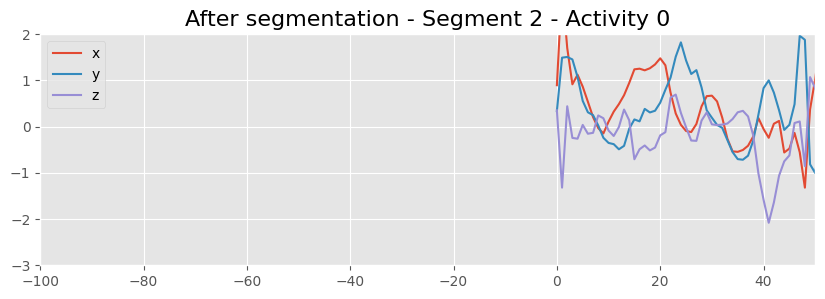

In [16]:
for i in range(3):
    plot_accelerometer_timeseries(segmented_data['train']['data'][i], f"After segmentation - Segment {i} - Activity {segmented_data['train']['labels'][i]}", xlim=(-i*50, 150-i*50), ylim=(-3,2), figsize=(10,3))

## 1.1 **Extracting features: ECDF**

In [17]:
# Computing the ECDF features
ecdf_features = ecdf.compute_ecdf_features(segmented_data=segmented_data)

  0%|          | 0/3 [00:00<?, ?it/s]

train (17677, 78)
val (4903, 78)
test (6092, 78)


## 1.2 **Training a Random Forest classifier with ECDF features for Activity Recognition**

In [18]:
# Training the RF classifier
trained_classifier, log_ecdf = ecdf.train_rf_classifier(ecdf=ecdf_features, segmented_data=segmented_data)

Phase: train, mean F1-score: 1.0
Phase: val, mean F1-score: 0.7295604631208708
Phase: test, mean F1-score: 0.8184197467863216


In [19]:
confusion_matrix_ecdf = confusion_matrix(segmented_data["test"]["labels"], trained_classifier.predict(ecdf_features["test"]))
confusion_matrix_ecdf_norm = confusion_matrix_ecdf / np.sum(confusion_matrix_ecdf, axis=1, keepdims=True)
os.makedirs(os.path.join(repo, "ecdf", "saved_logs", "current"), exist_ok=True)
with open(os.path.join(repo, "ecdf", "saved_logs", "current", "ecdf_eval_log.pkl"), 'wb') as f:
  pickle.dump(
      {"cm": confusion_matrix_ecdf_norm,
       "f1": log_ecdf
      },
  f)

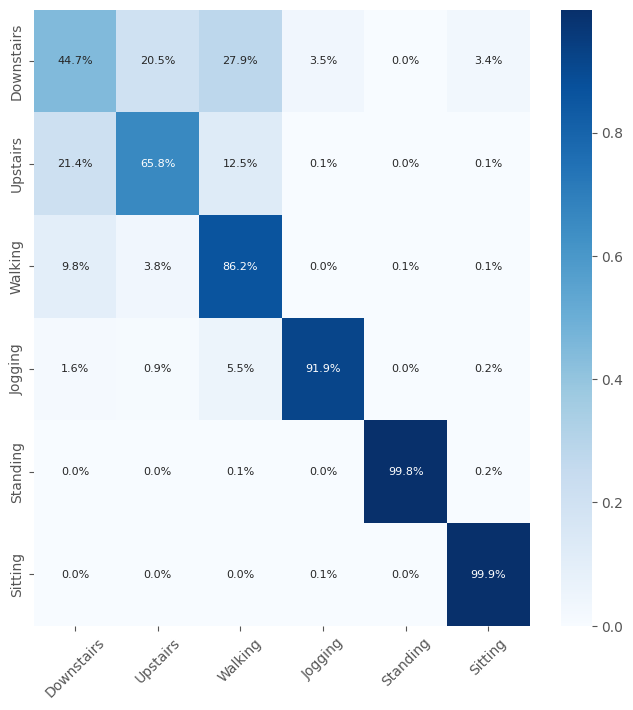

In [20]:
plt.figure(figsize=(8, 8))
sns.heatmap(confusion_matrix_ecdf_norm, annot=True, fmt='.1%', cmap='Blues', annot_kws={"fontsize":8}, yticklabels=cm_ticklabels, xticklabels=cm_ticklabels)
plt.xticks(rotation=45)
plt.show()

# 2 Convolutional Classifier

In [21]:
from conv_classifier import evaluate_with_classifier
from conv_classifier import model
from conv_classifier import arguments_dict
from conv_classifier import utils


In [22]:
args = arguments_dict.load_args()
print(args)

{'window': 100, 'overlap': 50, 'input_size': 3, 'dataset': 'motionsense', 'root_dir': '', 'data_file': 'motionsense.pkl', 'num_classes': 6, 'learning_rate': 0.0001, 'weight_decay': 0.0001, 'batch_size': 256, 'num_epochs': 50, 'classifier_lr': 0.0001, 'classifier_wd': 0.0001, 'classification_model': 'mlp', 'random_seed': 42, 'device': device(type='cuda', index=0)}


In [23]:
processed_data_files = glob.glob(os.path.join(repo, "data_preparation", "all_data", "*", "motionsense.pkl"))
processed_data_files.sort(key=os.path.getmtime)
processed_data_file = processed_data_files[-1]

In [24]:
args['root_dir'] = os.path.split(processed_data_file)[0]

In [25]:
print(model.Classifier(args=args))

Conv1d(3, 32, kernel_size=(24,), stride=(1,))
Conv1d(32, 64, kernel_size=(16,), stride=(1,))
Conv1d(64, 96, kernel_size=(8,), stride=(1,))
Classifier(
  (backbone): Encoder(
    (conv1): ConvBlock(
      (conv): Conv1d(3, 32, kernel_size=(24,), stride=(1,))
      (relu): ReLU()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (conv2): ConvBlock(
      (conv): Conv1d(32, 64, kernel_size=(16,), stride=(1,))
      (relu): ReLU()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (conv3): ConvBlock(
      (conv): Conv1d(64, 96, kernel_size=(8,), stride=(1,))
      (relu): ReLU()
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (softmax): Sequential(
    (0): Linear(in_features=96, out_features=1024, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=1024, out_features=6, bias=True)
  )
)


In [26]:
utils.set_all_seeds(args['random_seed'])
args['num_epochs'] = 50

In [27]:
evaluate_with_classifier(args=args)

{'window': 100, 'overlap': 50, 'input_size': 3, 'dataset': 'motionsense', 'root_dir': '/content/gdrive/MyDrive/ubicomp2024_soar/soar_2024/data_preparation/all_data/Jan-27-2025', 'data_file': 'motionsense.pkl', 'num_classes': 6, 'learning_rate': 0.0001, 'weight_decay': 0.0001, 'batch_size': 256, 'num_epochs': 50, 'classifier_lr': 0.0001, 'classifier_wd': 0.0001, 'classification_model': 'mlp', 'random_seed': 42, 'device': device(type='cuda', index=0)}
Data loading completed in 0m 0s
The dataset is: motionsense. The phase is: train. The size of the dataset is: (17677, 100, 3)
Data loading completed in 0m 0s
The dataset is: motionsense. The phase is: val. The size of the dataset is: (4903, 100, 3)
Data loading completed in 0m 0s
The dataset is: motionsense. The phase is: test. The size of the dataset is: (6092, 100, 3)
Conv1d(3, 32, kernel_size=(24,), stride=(1,))
Conv1d(32, 64, kernel_size=(16,), stride=(1,))
Conv1d(64, 96, kernel_size=(8,), stride=(1,))


  0%|          | 0/50 [00:00<?, ?it/s]

The best epoch is 3
Phase: train, loss: 0.194279910221341, accuracy: 0.9481246817898965, f1_score: 0.9299413042987151, f1_score weighted: 0.9470774174369628
Phase: val, loss: 0.3546179404203779, accuracy: 0.903936365490516, f1_score: 0.8741286403939444, f1_score weighted: 0.8995601588135448
Phase: test, loss: 0.30702936143607623, accuracy: 0.8931385423506237, f1_score: 0.8510065694943653, f1_score weighted: 0.8910322938612828


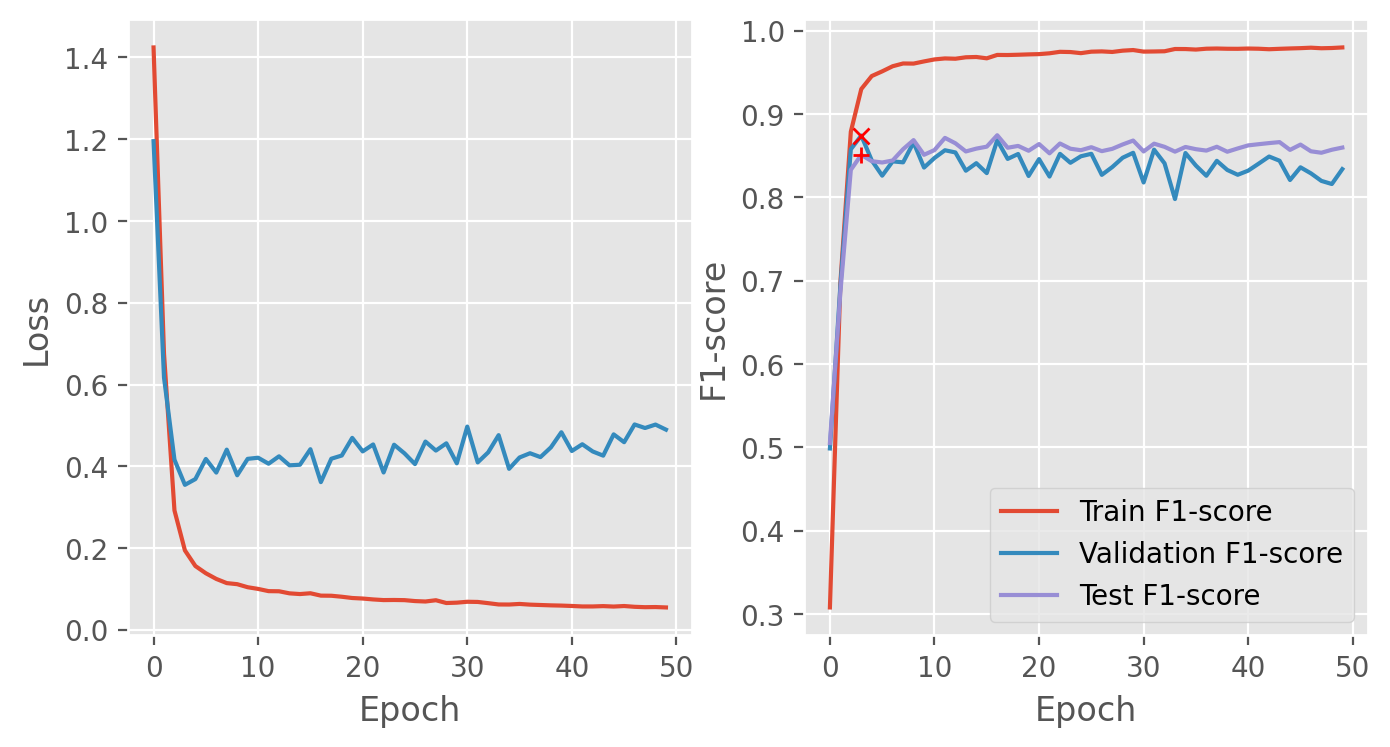

In [28]:
# First we load the logs
log_files = glob.glob(os.path.join(repo, "conv_classifier", "saved_logs", "*", "classifier*_log.pkl"))
log_files.sort(key=os.path.getmtime)
log_file = log_files[-1]
logs_simclr = pd.read_pickle(log_file)


plt.figure(dpi=200, figsize=(8, 4))
plt.style.use('ggplot')

plt.subplot(1, 2, 1)
plt.plot(np.arange(len(logs_simclr.loss['train'])), logs_simclr.loss['train'], label='Train loss')
plt.plot(np.arange(len(logs_simclr.loss['val'])), logs_simclr.loss['val'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(np.arange(len(logs_simclr.f1_score['train'])), logs_simclr.f1_score['train'], label='Train F1-score')
plt.plot(np.arange(len(logs_simclr.f1_score['val'])), logs_simclr.f1_score['val'], label='Validation F1-score')
plt.plot(np.arange(len(logs_simclr.f1_score['test'])), logs_simclr.f1_score['test'], label='Test F1-score')

# plotting the best val F1-score
plt.plot(logs_simclr.best_meter.epoch, logs_simclr.best_meter.f1_score['val'], 'rx')
plt.plot(logs_simclr.best_meter.epoch, logs_simclr.best_meter.f1_score['test'], 'r+')

plt.xlabel('Epoch')
plt.ylabel('F1-score')

plt.legend()

# 3 SimCLR for learning representations

## 3.0 Import & Data loading

In [ ]:
from simclr import arguments_dict
from simclr import utils
from simclr import pretrainer
from simclr import model

In [ ]:
args = arguments_dict.load_args()
print(args)

{'window': 100, 'overlap': 50, 'input_size': 3, 'dataset': 'motionsense', 'root_dir': '', 'data_file': 'motionsense.pkl', 'num_classes': 6, 'batch_size': 1024, 'learning_rate': 0.001, 'weight_decay': 1e-05, 'num_epochs': 50, 'patience': 15, 'classifier_lr': 0.001, 'classifier_wd': 0.0, 'classifier_batch_size': 256, 'saved_model_folder': '/', 'learning_schedule': 'last_layer', 'classification_model': 'mlp', 'random_seed': 0, 'device': device(type='cuda', index=0)}


Updating the location of the processed data.

In [ ]:
processed_data_files = glob.glob(os.path.join(repo, "data_preparation", "all_data", "*", "motionsense.pkl"))
processed_data_files.sort(key=os.path.getmtime)
processed_data_file = processed_data_files[-1]

In [ ]:
args['root_dir'] = os.path.split(processed_data_file)[0]

## 3.1 Pre-training using SimCLR

Setting the seeds for pre-training

In [ ]:
utils.set_all_seeds(args['random_seed'])

Next, let us print the SimCLR model architecture

In [ ]:
simclr_model = model.SimCLR(args=args)
print(simclr_model)

Conv1d(3, 32, kernel_size=(24,), stride=(1,))
Conv1d(32, 64, kernel_size=(16,), stride=(1,))
Conv1d(64, 96, kernel_size=(8,), stride=(1,))
SimCLR(
  (backbone): Encoder(
    (conv1): ConvBlock(
      (conv): Conv1d(3, 32, kernel_size=(24,), stride=(1,))
      (relu): ReLU()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (conv2): ConvBlock(
      (conv): Conv1d(32, 64, kernel_size=(16,), stride=(1,))
      (relu): ReLU()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (conv3): ConvBlock(
      (conv): Conv1d(64, 96, kernel_size=(8,), stride=(1,))
      (relu): ReLU()
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (projection_head): Sequential(
    (0): Linear(in_features=96, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=50, bias=True)
  )
)


### Starting the pre-training using the SimCLR

In [ ]:
pretrainer.learn_model(args=args)

Starting the pre-training
{'window': 100, 'overlap': 50, 'input_size': 3, 'dataset': 'motionsense', 'root_dir': '/content/gdrive/MyDrive/ubicomp2024_soar/soar_2024/data_preparation/all_data/Nov-01-2024', 'data_file': 'motionsense.pkl', 'num_classes': 6, 'batch_size': 1024, 'learning_rate': 0.001, 'weight_decay': 1e-05, 'num_epochs': 50, 'patience': 15, 'classifier_lr': 0.001, 'classifier_wd': 0.0, 'classifier_batch_size': 256, 'saved_model_folder': '/', 'learning_schedule': 'last_layer', 'classification_model': 'mlp', 'random_seed': 0, 'device': device(type='cuda', index=0)}
Data loading completed in 0m 0s
The dataset is: motionsense. The phase is: train. The size of the dataset is: (17677, 100, 3)
Data loading completed in 0m 0s
The dataset is: motionsense. The phase is: val. The size of the dataset is: (4903, 100, 3)
Data loading completed in 0m 0s
The dataset is: motionsense. The phase is: test. The size of the dataset is: (6092, 100, 3)
Conv1d(3, 32, kernel_size=(24,), stride=(1,))

  0%|          | 0/50 [00:00<?, ?it/s]

Updating the best val loss at epoch: 0, since 7.11630225225344 < inf
Updating the best val loss at epoch: 1, since 7.005084406276783 < 7.11630225225344
Updating the best val loss at epoch: 2, since 6.905760799892674 < 7.005084406276783
Updating the best val loss at epoch: 3, since 6.67736090316399 < 6.905760799892674
Updating the best val loss at epoch: 4, since 6.58133525389349 < 6.67736090316399
Updating the best val loss at epoch: 5, since 6.508247183703073 < 6.58133525389349
Updating the best val loss at epoch: 7, since 6.475015878531487 < 6.508247183703073
Updating the best val loss at epoch: 9, since 6.443197847993039 < 6.475015878531487
Updating the best val loss at epoch: 11, since 6.347955982854797 < 6.443197847993039
Updating the best val loss at epoch: 13, since 6.305862945511515 < 6.347955982854797
Updating the best val loss at epoch: 15, since 6.264848490868105 < 6.305862945511515
Updating the best val loss at epoch: 16, since 6.233290580883334 < 6.264848490868105
Updating

### Plotting the loss values to see the trends

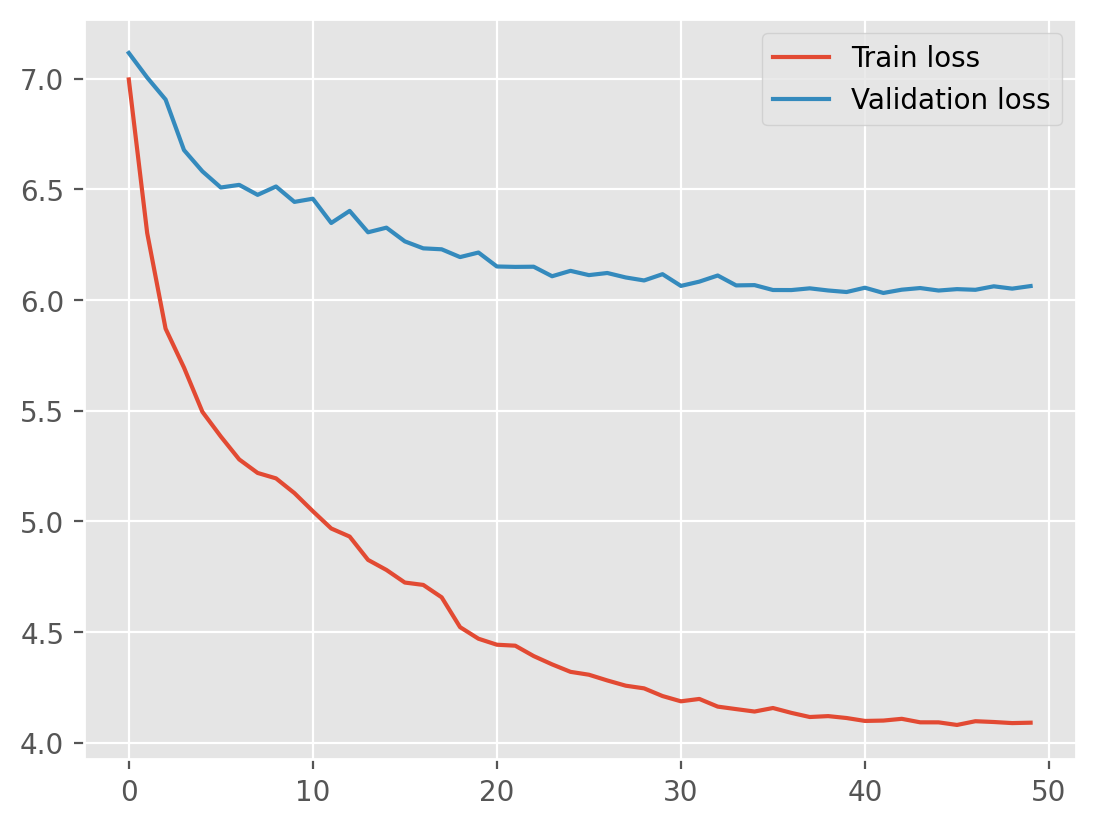

In [ ]:
# First we load the logs
log_files = glob.glob(os.path.join(repo, "simclr", "saved_logs", "*", "simclr_*.pkl"))
log_files.sort(key=os.path.getmtime)
log_files = list(filter(lambda x: not x.endswith("_eval_log.pkl"), log_files))
log_file = log_files[-1]
logs = pd.read_pickle(log_file)

plt.figure(dpi=200)
plt.style.use('ggplot')

plt.plot(np.arange(len(logs.loss['train'])), logs.loss['train'], label='Train loss')
plt.plot(np.arange(len(logs.loss['val'])), logs.loss['val'], label='Validation loss')

plt.legend()

## 3.2 Classification with the learned features.

For that, we first set the location of the trained model, so we can load the learned weights  

In [ ]:
from simclr import evaluate_with_classifier

In [ ]:
print(model.Classifier(args=args))

Conv1d(3, 32, kernel_size=(24,), stride=(1,))
Conv1d(32, 64, kernel_size=(16,), stride=(1,))
Conv1d(64, 96, kernel_size=(8,), stride=(1,))
Classifier(
  (backbone): Encoder(
    (conv1): ConvBlock(
      (conv): Conv1d(3, 32, kernel_size=(24,), stride=(1,))
      (relu): ReLU()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (conv2): ConvBlock(
      (conv): Conv1d(32, 64, kernel_size=(16,), stride=(1,))
      (relu): ReLU()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (conv3): ConvBlock(
      (conv): Conv1d(64, 96, kernel_size=(8,), stride=(1,))
      (relu): ReLU()
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (softmax): Sequential(
    (0): Linear(in_features=96, out_features=1024, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=1024, out_features=6, bias=True)
  )
)


In [ ]:
saved_model_folders = glob.glob(os.path.join(repo, "simclr", "saved_weights", "*"))
saved_model_folders.sort(key=os.path.getmtime)
saved_model_folder = saved_model_folders[-1]

args['saved_model_folder'] = saved_model_folder

In [ ]:
evaluate_with_classifier(args=args)

{'window': 100, 'overlap': 50, 'input_size': 3, 'dataset': 'motionsense', 'root_dir': '/content/gdrive/MyDrive/ubicomp2024_soar/soar_2024/data_preparation/all_data/Nov-01-2024', 'data_file': 'motionsense.pkl', 'num_classes': 6, 'batch_size': 1024, 'learning_rate': 0.001, 'weight_decay': 1e-05, 'num_epochs': 50, 'patience': 15, 'classifier_lr': 0.001, 'classifier_wd': 0.0, 'classifier_batch_size': 256, 'saved_model_folder': '/content/gdrive/MyDrive/ubicomp2024_soar/soar_2024/simclr/saved_weights/Nov-01-2024', 'learning_schedule': 'last_layer', 'classification_model': 'mlp', 'random_seed': 0, 'device': device(type='cuda', index=0), 'saved_model': '/content/gdrive/MyDrive/ubicomp2024_soar/soar_2024/simclr/saved_weights/Nov-01-2024/simclr_motionsense_0.001_wd_1e-05_1024_rs_0.pkl'}
Data loading completed in 0m 0s
The dataset is: motionsense. The phase is: train. The size of the dataset is: (17677, 100, 3)
Data loading completed in 0m 0s
The dataset is: motionsense. The phase is: val. The si

/content/gdrive/MyDrive/ubicomp2024_soar/soar_2024/simclr/model.py:116: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(state_dict_path, map_location=a

  0%|          | 0/50 [00:00<?, ?it/s]

The best epoch is 24
Phase: train, loss: 0.008733027622608629, accuracy: 0.9981897380777282, f1_score: 0.9978375877730001, f1_score weighted: 0.9981891207707289
Phase: val, loss: 0.4686886379338792, accuracy: 0.8723230675096879, f1_score: 0.8384920098108853, f1_score weighted: 0.8709850189413301
Phase: test, loss: 0.5715382746231998, accuracy: 0.870978332239002, f1_score: 0.8317264669314114, f1_score weighted: 0.8757736823258914


### We can now plot the loss and f1-scores to see how performance improved.

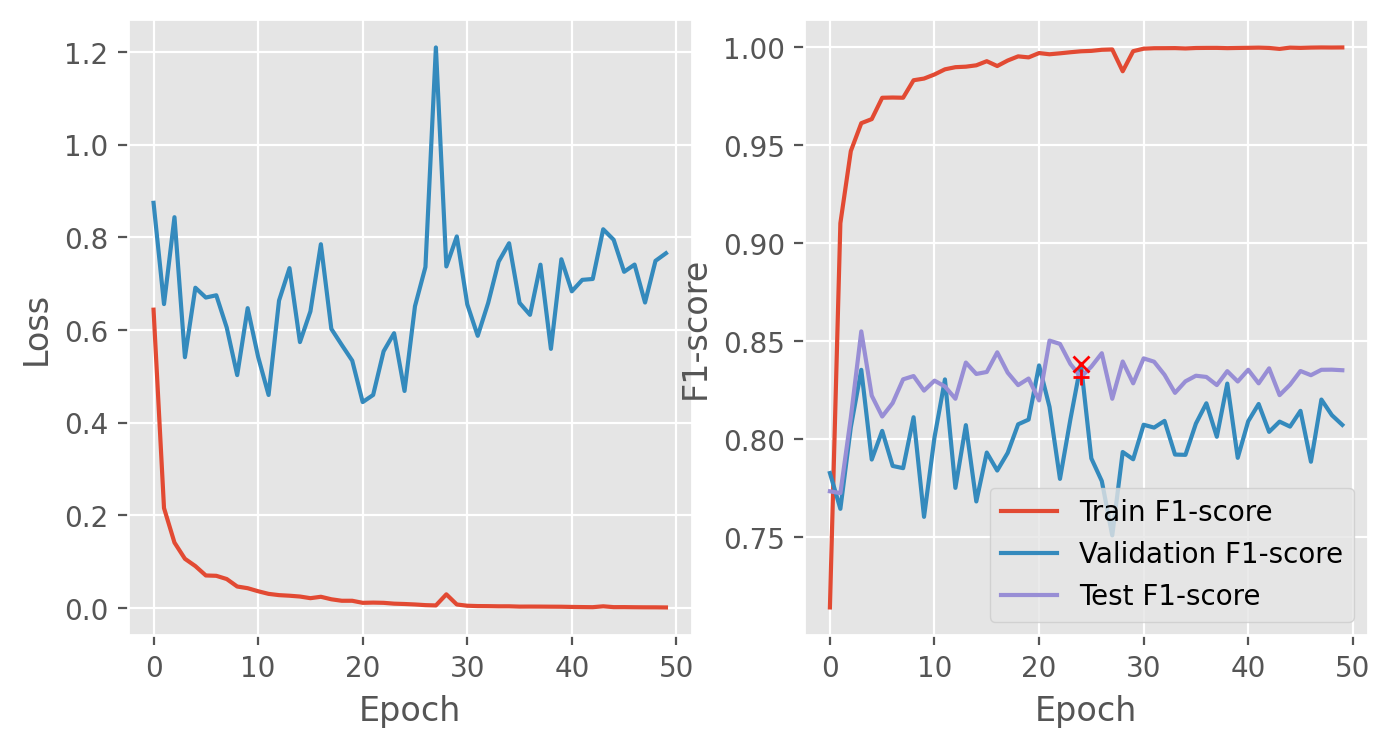

In [ ]:
# First we load the logs
log_files = glob.glob(os.path.join(repo, "simclr", "saved_logs", "*", "simclr*_eval_log.pkl"))
log_files.sort(key=os.path.getmtime)
log_file = log_files[-1]
logs_simclr = pd.read_pickle(log_file)


plt.figure(dpi=200, figsize=(8, 4))
plt.style.use('ggplot')

plt.subplot(1, 2, 1)
plt.plot(np.arange(len(logs_simclr.loss['train'])), logs_simclr.loss['train'], label='Train loss')
plt.plot(np.arange(len(logs_simclr.loss['val'])), logs_simclr.loss['val'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(np.arange(len(logs_simclr.f1_score['train'])), logs_simclr.f1_score['train'], label='Train F1-score')
plt.plot(np.arange(len(logs_simclr.f1_score['val'])), logs_simclr.f1_score['val'], label='Validation F1-score')
plt.plot(np.arange(len(logs_simclr.f1_score['test'])), logs_simclr.f1_score['test'], label='Test F1-score')

# plotting the best val F1-score
plt.plot(logs_simclr.best_meter.epoch, logs_simclr.best_meter.f1_score['val'], 'rx')
plt.plot(logs_simclr.best_meter.epoch, logs_simclr.best_meter.f1_score['test'], 'r+')

plt.xlabel('Epoch')
plt.ylabel('F1-score')

plt.legend()

We can also visualize the confusion matrix to see where the classes get confused.

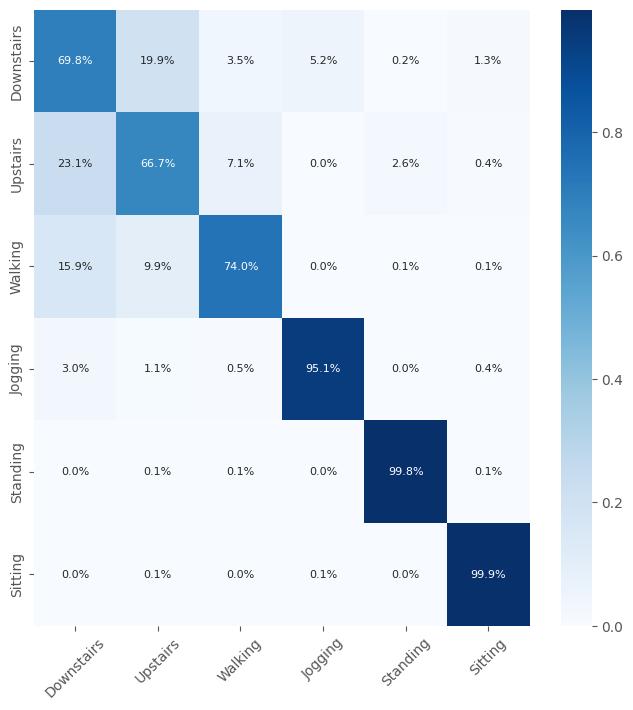

In [ ]:
plt.figure(figsize=(8, 8))
sns.heatmap(logs_simclr.best_meter.confusion_matrix['test'], annot=True, fmt='.1%', cmap='Blues', annot_kws={"fontsize":8}, yticklabels=cm_ticklabels, xticklabels=cm_ticklabels)
plt.xticks(rotation=45)
plt.show()

# 4 Result comparison

In [ ]:
with open(os.path.join(repo, "ecdf", "saved_logs", "current", "ecdf_eval_log.pkl"), 'rb') as f:
    ecdf_obj = pickle.load(f)
    confusion_matrix_ecdf_norm = ecdf_obj["cm"]
    f1_ecdf_test = ecdf_obj["f1"]["test"]

log_files = glob.glob(os.path.join(repo, "conv_classifier", "saved_logs", "*", "classifier*_eval_log.pkl"))
log_files.sort(key=os.path.getmtime)
log_file = log_files[-1]
logs_conv_classifier = pd.read_pickle(log_file)

log_files = glob.glob(os.path.join(repo, "simclr", "saved_logs", "*", "simclr*_eval_log.pkl"))
log_files.sort(key=os.path.getmtime)
log_file = log_files[-1]
logs_simclr = pd.read_pickle(log_file)

confusion_matrices = {
    "ECDF": confusion_matrix_ecdf_norm,
    "Conv. classifier": logs_conv_classifier.best_meter.confusion_matrix['test'],
    "SimCLR": logs_simclr.best_meter.confusion_matrix['test']
}

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 1920x1440 with 0 Axes>

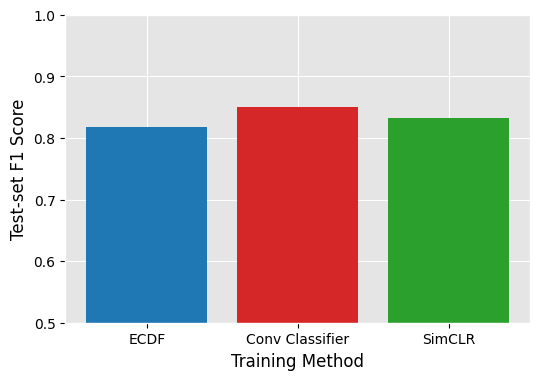

In [ ]:
plt.figure(dpi=300)

fig, axs = plt.subplots(1, 1, figsize=(6, 4))
plt.bar(
    ["ECDF", "Conv Classifier", "SimCLR"],
    [
        f1_ecdf_test,
        logs_conv_classifier.best_meter.f1_score['test'],
        logs_simclr.best_meter.f1_score['test']
    ],
    color=['tab:blue', 'tab:red', 'tab:green']
)

axs.xaxis.label.set_color('black') # x-axis labels
axs.yaxis.label.set_color('black') # y-axis labels

axs.tick_params(axis='x', colors='black')    #setting up X-axis tick color to red
axs.tick_params(axis='y', colors='black')  #setting up Y-axis tick color to black

plt.ylim([0.5, 1.0])
plt.ylabel("Test-set F1 Score")
plt.xlabel("Training Method")

plt.savefig("exp_all_perf.pdf", bbox_inches='tight')
files.download("exp_all_perf.pdf")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

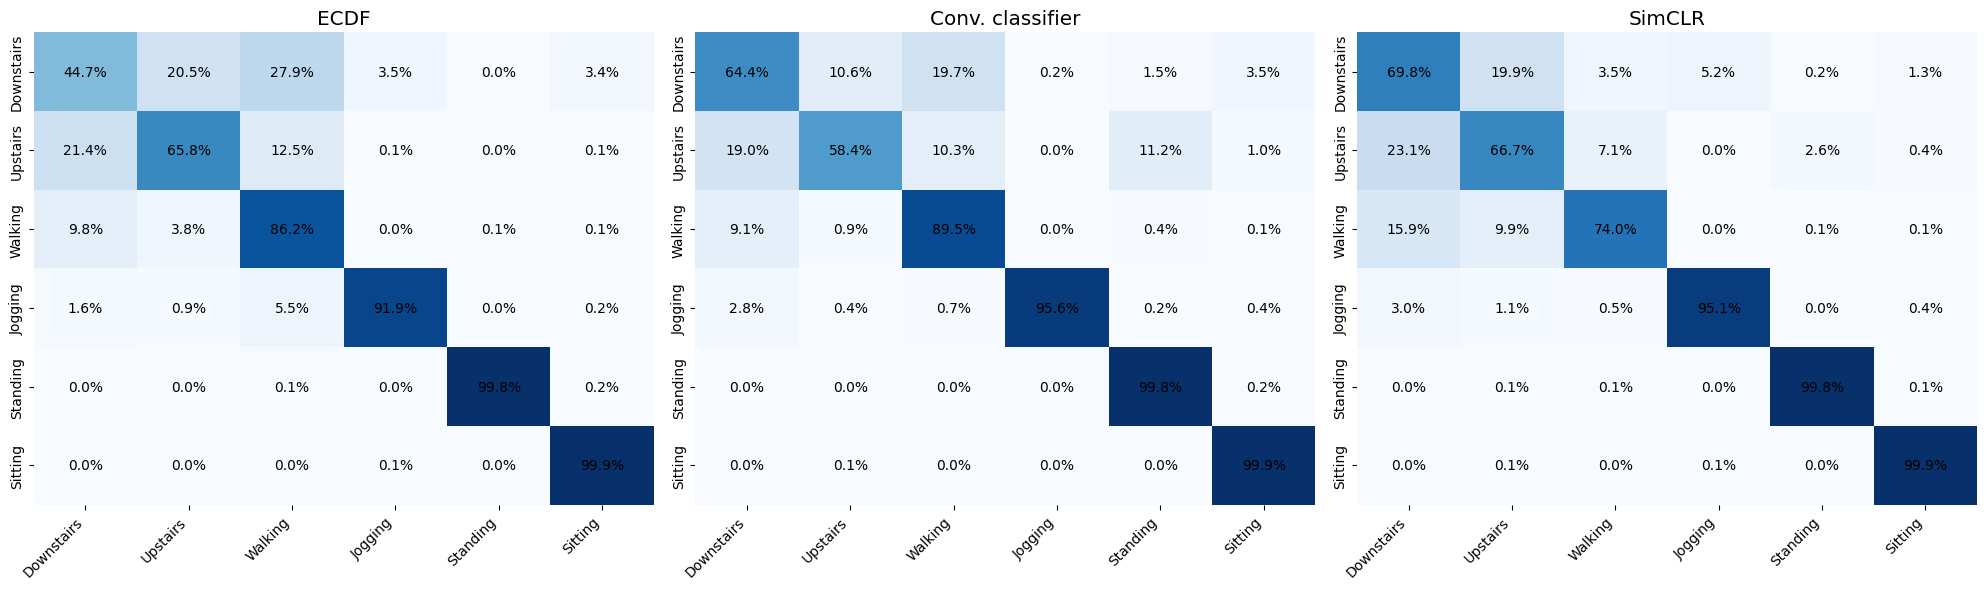

In [ ]:
fig, axs = plt.subplots(ncols=3, figsize=(20, 6))
for i, method in enumerate(confusion_matrices):
    sns.heatmap(
        confusion_matrices[method],
        ax=axs[i],
        annot=True, fmt='.1%', cmap='Blues', annot_kws={"fontsize":10, "color": 'black'},
        vmin=0, vmax=1, cbar=False,
        yticklabels=cm_ticklabels, xticklabels=cm_ticklabels
    )
    axs[i].set_xticks(axs[i].get_xticks())
    axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=45, ha='right', fontsize=12)
    axs[i].tick_params(axis='both', which='major', labelsize=10)
    axs[i].set_title(method)

    axs[i].xaxis.label.set_color('black') # x-axis labels
    axs[i].yaxis.label.set_color('black') # y-axis labels

    axs[i].tick_params(axis='x', colors='black')    #setting up X-axis tick color to red
    axs[i].tick_params(axis='y', colors='black')  #setting up Y-axis tick color to black
fig.tight_layout()

plt.savefig("exp_all_conf_matrix.pdf", bbox_inches='tight')
files.download("exp_all_conf_matrix.pdf")